# Credit Card Customer Segmentation
This project is from the POV of a data scientist for a credit card company. We're asked to help segment company clients into different groups in order to apply different business strategies for each type of customer.

### First Steps
- Analyze the dataset
- Prepare the data for modeling
- Find an appropriate number of clusters
- Segment the data
- Interpret and explain

### Data Dictionary (for future reference)
- customer_id: unique identifier for each customer
- age: customer age in years
- gender: customer gender (M or F)
- dependent_count: number of dependents of each customer.
- education_level: level of education ("High School", "Graduate", etc.).
- marital_status: marital status ("Single", "Married", etc.).
- estimated_income: the estimated income for the customer projected by the data science team.
- months_on_book: time as a customer in months.
- total_relationship_count: number of times the customer contacted the company.
- months_inactive_12_mon: number of months the customer did not use the credit card in the last 12 months.
- credit_limit: customer's credit limit.
- total_trans_amount: the overall amount of money spent on the card by the customer.
- total_trans_count: the overall number of times the customer used the card.
- avg_utilization_ratio: daily average utilization ratio.

## Loading Data and Overview

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')

In [34]:
data = pd.read_csv('customer_segmentation.csv')
data.shape

(10127, 14)

In [35]:
data.dtypes

customer_id                   int64
age                           int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
estimated_income              int64
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
credit_limit                float64
total_trans_amount            int64
total_trans_count             int64
avg_utilization_ratio       float64
dtype: object

In [36]:
data.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [37]:
null_values = pd.DataFrame(data.isnull().value_counts())
null_values

,,,,,,,,,,,,,,0
customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,
False,False,False,False,False,False,False,False,False,False,False,False,False,False,10127


In [38]:
numeric_data = data.drop(columns = ['gender', 'education_level',
                                    'marital_status'])

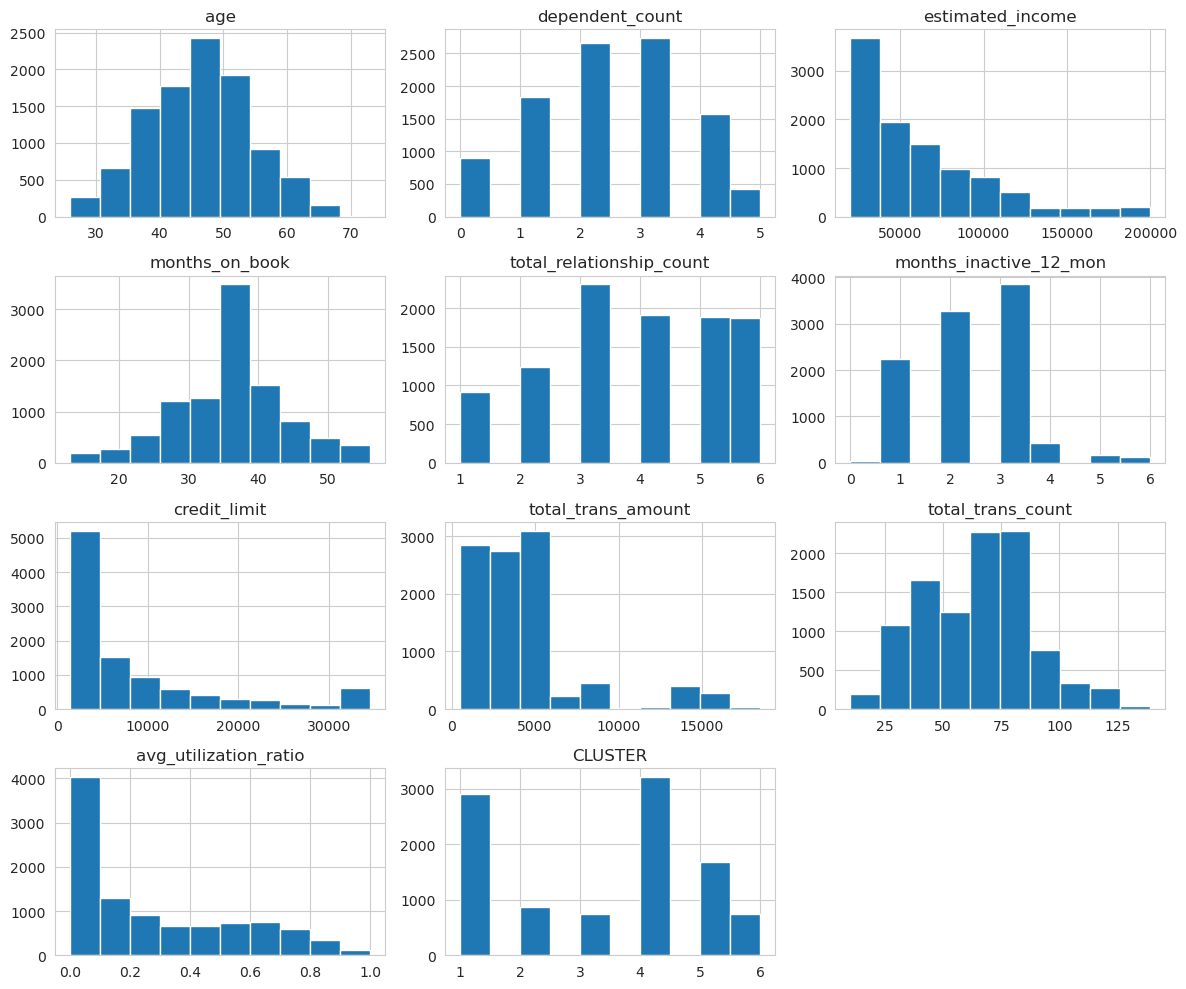

In [67]:
fig, ax = plt.subplots(figsize=(12, 10))

#Removing the customer's id before plotting the distributions
data.drop('customer_id', axis=1).hist(ax=ax)

plt.tight_layout()
plt.show()

There are ~10,000 rows in this dataset with 14 columns, 3 of said columns being categorical. The dataset has no null values, but among the numerical columns there is some skewedness:

These columns are skewed pretty heavily:
- customer_id
- estimated_income
- months_inactive
- credit_limit
- total_trans_amount
- avg_utilization_ratio

### Categorical Column Transformations

In [40]:
customers_modif = data.copy()

In [41]:
customers_modif['gender'] = customers_modif['gender'].map({'M' : 1,
                                                           'F' : 0})
#Change gender column to binary

In [42]:
customers_modif['education_level'] = (
    customers_modif['education_level'].map({'Uneducated' : 0,
                                   'High School' : 1,
                                  'College' : 2, 
                                  'Graduate' : 3,
                                  'Post-Graduate' : 4,
                                  'Doctorate' : 5}))

In [43]:
customers_modif = pd.get_dummies(customers_modif, 'marital_status')

In [44]:
customers_modif #Checking new columns

,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,0,1,0,0
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,0,1,0
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,0,1,0,0
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,0,1
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,1,2,3,51000,40,3,2,4003.0,15476,117,0.462,0,0,1,0
10123,710638233,41,1,2,3,40000,25,4,2,4277.0,8764,69,0.511,1,0,0,0
10124,716506083,44,0,1,1,33000,36,5,3,5409.0,10291,60,0.000,0,1,0,0
10125,717406983,30,1,2,3,47000,36,4,3,5281.0,8395,62,0.000,0,0,0,1


### Scaling Data
Across our dataframe, we have numerical columns with different scales of numbers. The estimated_income, for instance, contains numbers in the range of dozens and hundreds of thousands, while the dependent_count column contains numbers from 1 to 5. 

Now we should transform the data so it's all on the same scale. 

In [45]:
no_id = customers_modif.drop(columns = 'customer_id') #Drop customer id

In [46]:
scaler = StandardScaler() #initiate scaler
scaler.fit(no_id) #Fit the scaler
scaled_noid = scaler.transform(no_id) #Transform the data

In [47]:
scaled_noid[:5]

array([[-0.16540558,  1.05995565,  0.50336813, -0.75221102,  0.1758098 ,
         0.38462088,  0.76394261, -1.32713603,  0.4466219 , -0.95970657,
        -0.97389518, -0.77588223, -0.2824051 ,  1.07733799, -0.79850685,
        -0.28260887],
       [ 0.33357038, -0.9434357 ,  2.04319867,  0.66278684, -0.96716585,
         1.01071482,  1.40730617, -1.32713603, -0.04136665, -0.91643261,
        -1.35734038, -0.61627565, -0.2824051 , -0.92821381,  1.2523374 ,
        -0.28260887],
       [ 0.58305837,  1.05995565,  0.50336813,  0.66278684,  0.78539682,
         0.00896451,  0.12057905, -1.32713603, -0.5736978 , -0.74098169,
        -1.91120566, -0.99715499, -0.2824051 ,  1.07733799, -0.79850685,
        -0.28260887],
       [-0.78912553, -0.9434357 ,  1.2732834 , -0.75221102, -0.63697289,
        -0.24147306, -0.52278451,  1.64147829, -0.58525108, -0.95175829,
        -1.91120566,  1.75968594, -0.2824051 , -0.92821381, -0.79850685,
         3.53845931],
       [-0.78912553,  1.05995565,  0

### Machine Learning
First step for machine learning is deciding the best number of clusters to use in segmentation. We can plot an elbow curve to compare the inertias.

In [48]:
X = pd.DataFrame(scaled_noid)

inertias = []
for i in range(1,11):
    means = KMeans(n_clusters = i)
    means.fit_predict(X)
    inertia = means.inertia_
    inertias.append(inertia)

In [49]:
inertias

[162031.99999999997,
 144649.74481322523,
 132111.91416515448,
 122569.23360415414,
 111788.49668591382,
 103874.77687571246,
 98669.29467846229,
 94562.60231929293,
 91184.93729311766,
 88915.26099522371]

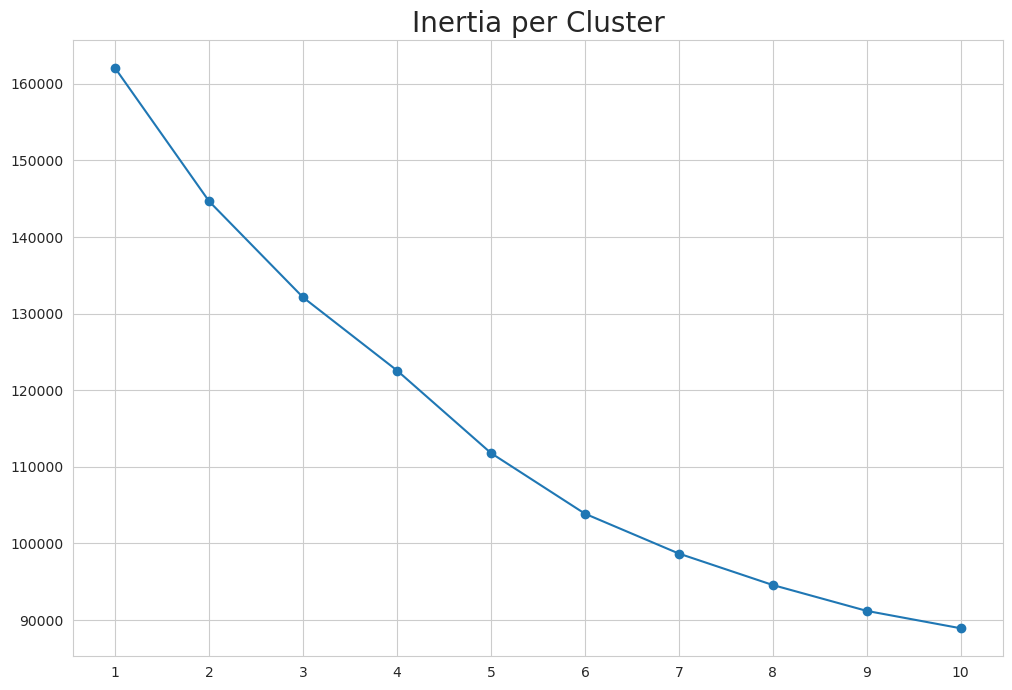

In [68]:
fig = plt.figure(figsize = (12,8))
xs = list(range(1,len(inertias)+1))
plt.plot(xs, inertias, marker = 'o')
plt.xticks(xs)
plt.title("Inertia per Cluster", size = 20)
plt.show()

It looks like inertia slows down around 6-7, so let's choose 6 clusters. 

In [51]:
six_cluster = KMeans(n_clusters = 6) #Initiate with 6 clusters

In [52]:
y = six_cluster.fit_predict(scaled_noid)

In [53]:
y

array([4, 0, 4, ..., 3, 2, 3], dtype=int32)

## Visualizing our clusters
First to visualize the clustering we just performed, we will plot bar charts of each numerical column grouped by cluster.

Then we will see what variables correlate highly and plot scatter plots to see how each cluster differs.

In [54]:
data['CLUSTER'] = y + 1
data['CLUSTER'].value_counts()

4    3208
1    2894
5    1671
2     875
3     740
6     739
Name: CLUSTER, dtype: int64

We see that cluster 2 is the largest and 3 has the smallest count.

Let's plot the numerical values to see how each cluster represents data.

In [55]:
numeric_columns = data.select_dtypes(
    include = np.number).drop(
    ['customer_id','CLUSTER'], axis = 1).columns
numeric_columns
# First selects data types that are numbers, drops the ones that 
# are irrelevant, such as id and cluster, then accesses them by .columns

Index(['age', 'dependent_count', 'estimated_income', 'months_on_book',
       'total_relationship_count', 'months_inactive_12_mon', 'credit_limit',
       'total_trans_amount', 'total_trans_count', 'avg_utilization_ratio'],
      dtype='object')

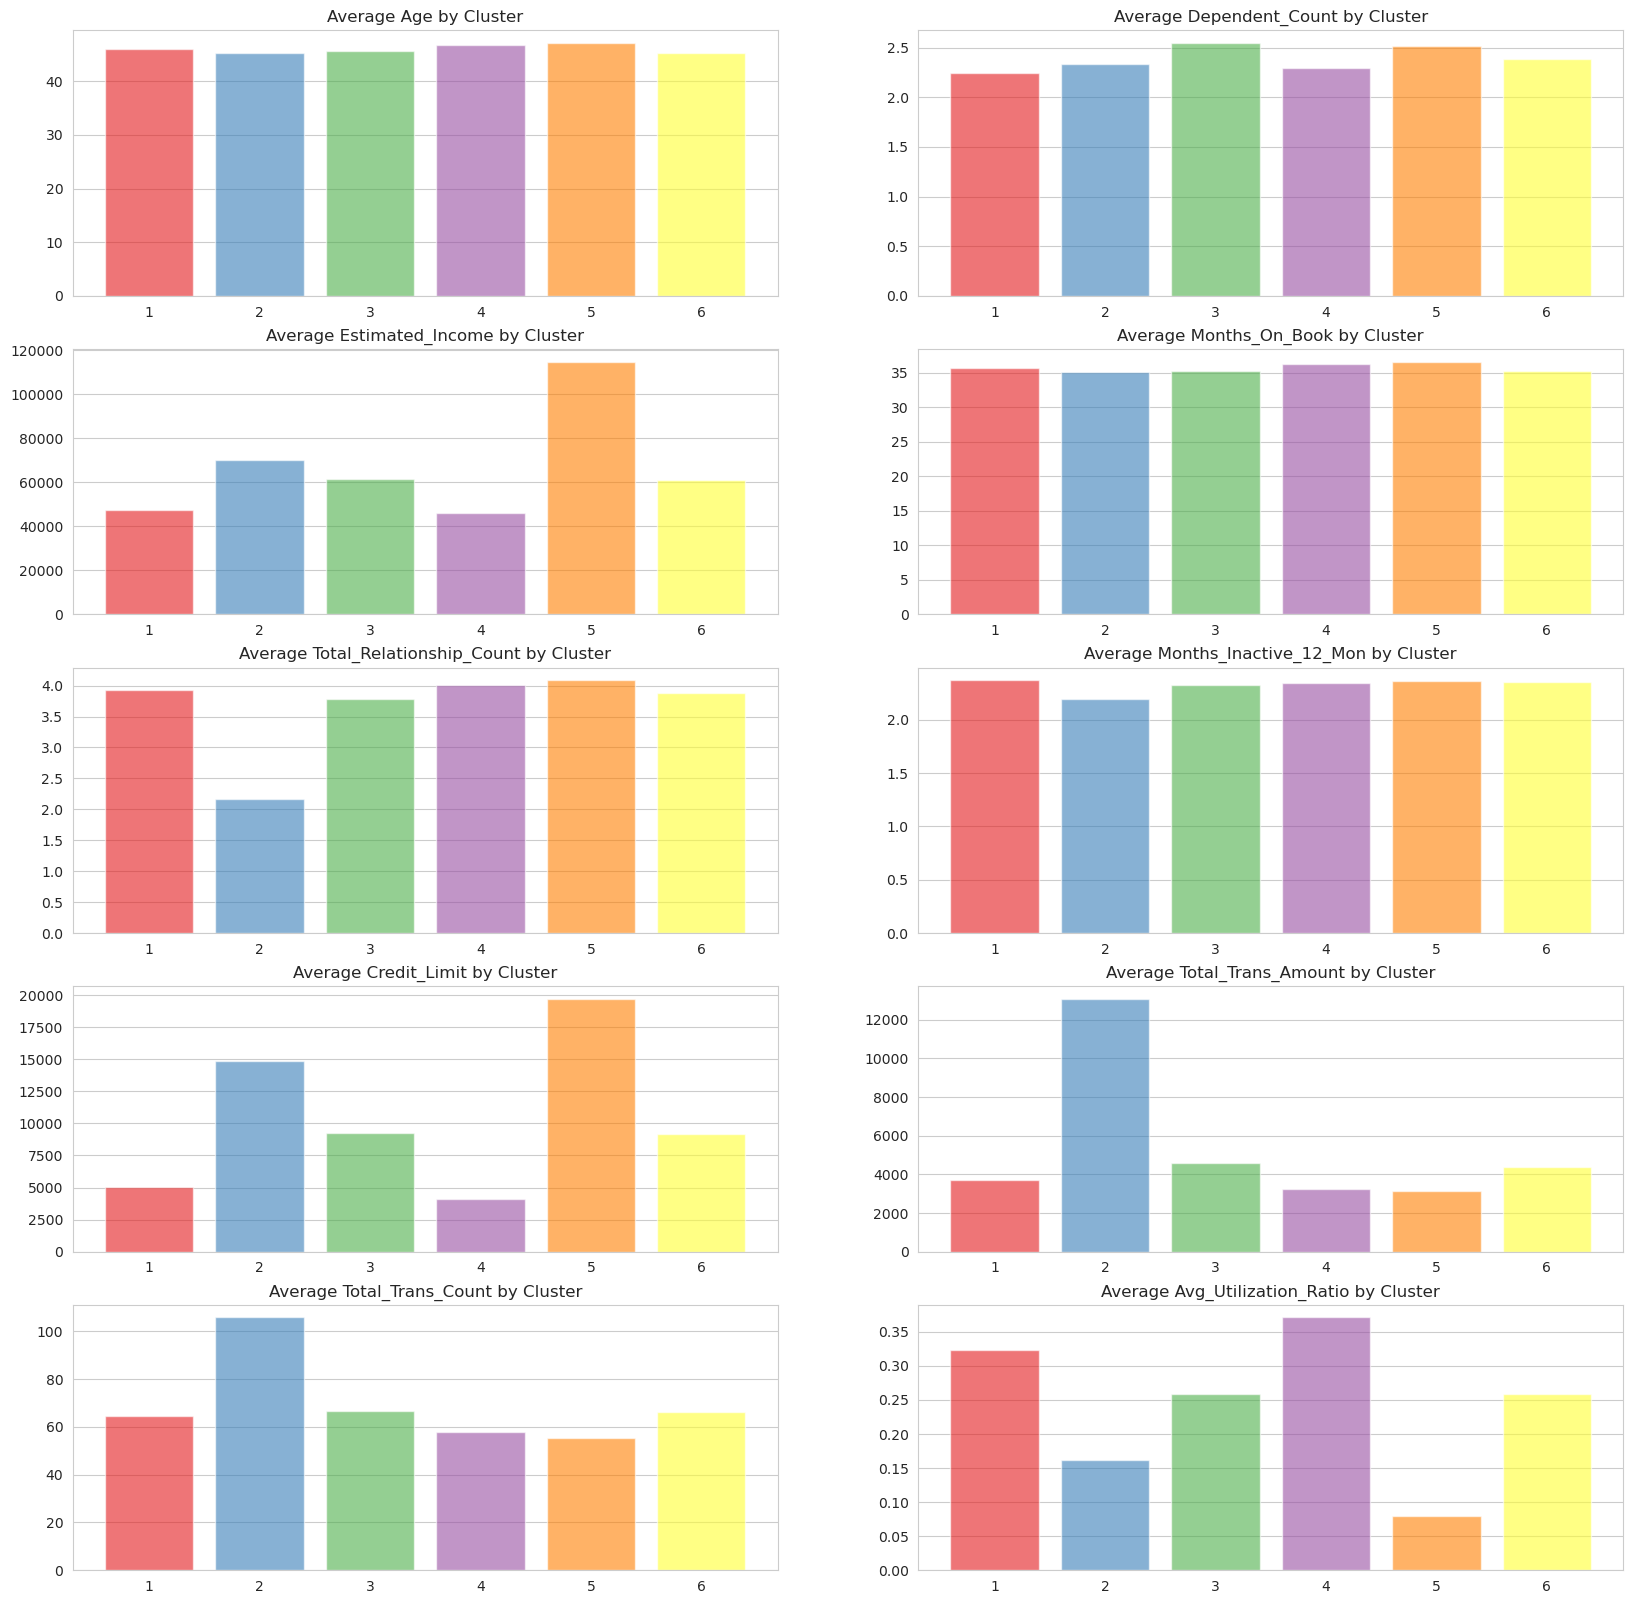

In [71]:
fig = plt.figure(figsize = (20,20)) #Set size of figure
for i, column in enumerate(numeric_columns): #Will return 0: column
    plot = data.groupby('CLUSTER')[column].mean() #Calculate by cluster
    ax = fig.add_subplot(5,2,i+1) #Adds subplot for each incoming column
    ax.bar(plot.index, plot, color = sns.color_palette('Set1'), alpha = 0.6)
    #Plots the clusters as x index, actual data as the y axis
    ax.set_title(f"Average {column.title()} by Cluster")
    ax.xaxis.grid(False)
    #Column.title transforms column name to appear better

From this plot we see several things:
- Estimated income is highest in cluster 4, with 2 and 6 having the lowest income. 
- Cluster 1 has the lowest relationship count. 
- Cluster 1 and 4 have the highest credit limit, and 2/6 have lowest (which correlates with the estimated income)
- Cluster 1 has a significantly higher spending average. The group also uses their card the most.
- Cluster 4 has the lowest utilization ratio, whereas cluster 2 has the highest.

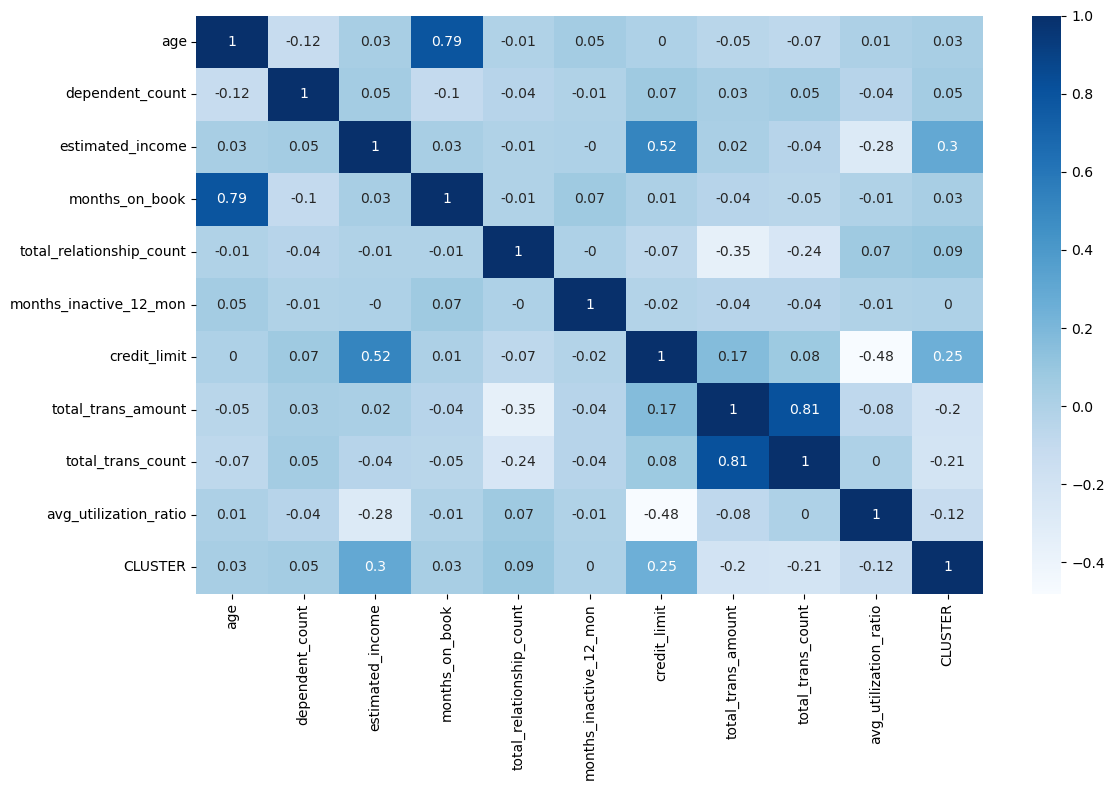

In [57]:
fig, ax = plt.subplots(figsize = (12,8))
sns.heatmap(round(data.drop('customer_id', axis = 1).corr(), 2),
           cmap = 'Blues', annot = True, ax = ax,
            annot_kws = {'fontsize' :10})
plt.tight_layout()
plt.show()

We see these correlations:
- age and months_on_book 
- credit_limit and estimated_income
- total_trans_count and total_trans_amount
- credit_limit and avg_utilization_ratio (negative correlation)

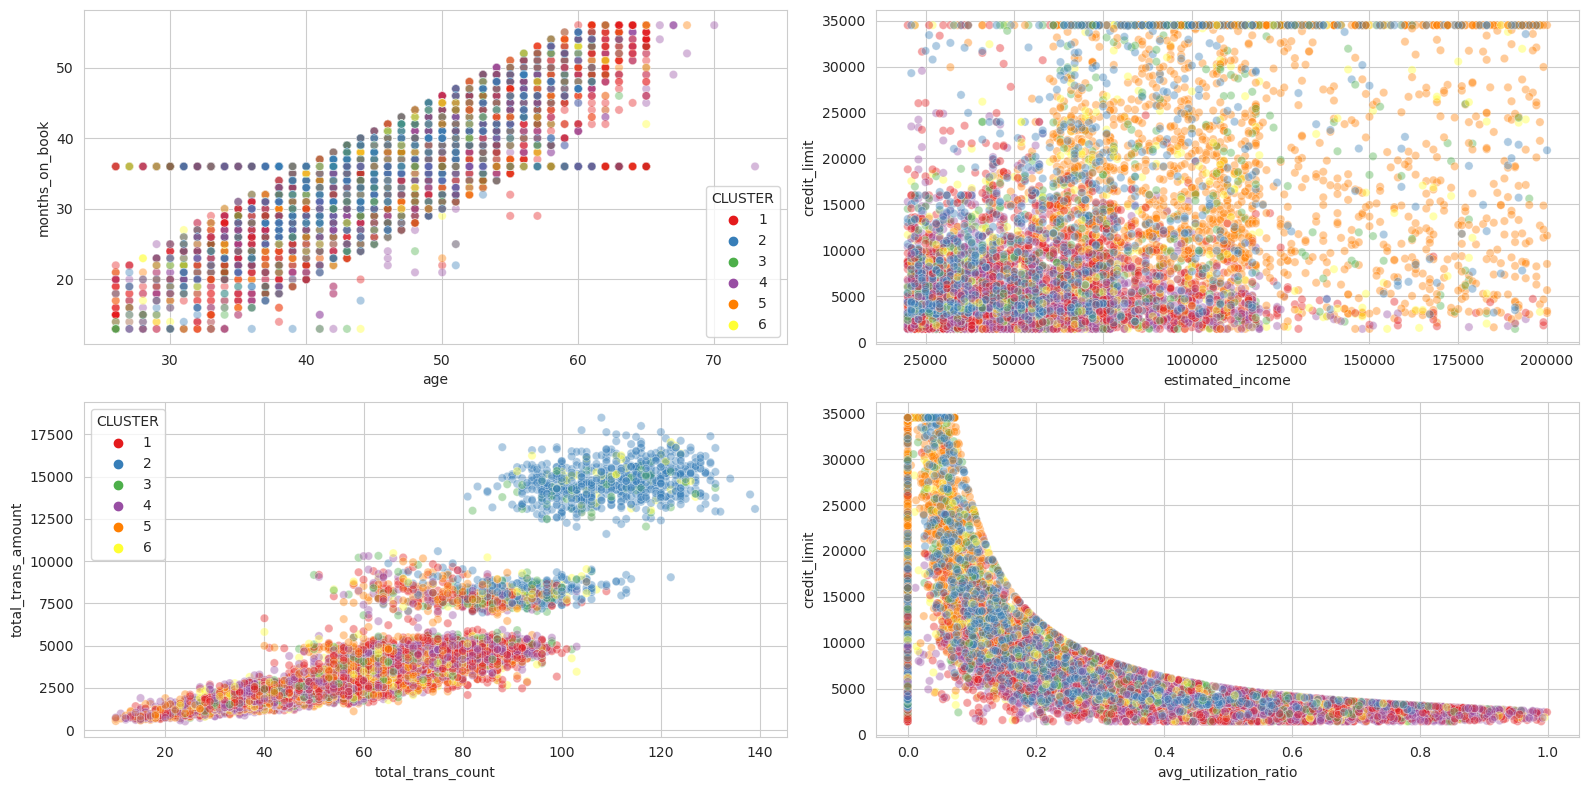

In [82]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, figsize = (16,8))
sns.scatterplot(data['age'], data['months_on_book'],
               hue = data['CLUSTER'], palette = 'Set1', ax = ax1, alpha = 0.4)
sns.scatterplot(data['estimated_income'], data['credit_limit'], 
                hue = data['CLUSTER'], palette = 'Set1', ax = ax2, alpha = 0.4,
               legend = False)
sns.scatterplot(data = data, x = 'total_trans_count', y = 'total_trans_amount',
                hue = 'CLUSTER', palette = 'Set1', ax = ax3, alpha = 0.4)
sns.scatterplot(data = data, x = 'avg_utilization_ratio', y = 'credit_limit',
                hue = 'CLUSTER', palette = 'Set1', ax = ax4, alpha = 0.4,
                legend = False)
plt.tight_layout()
plt.show()

There are some clear observations from these four plots. For example, older clients seem to be grouped in cluster 1. Higher income clients and those with higher credit limits are grouped together in 6. Group 2 and 3 have the highest use and amount spent on their card, even though their credit limit seems to be middle of the pack and they have lower income. 

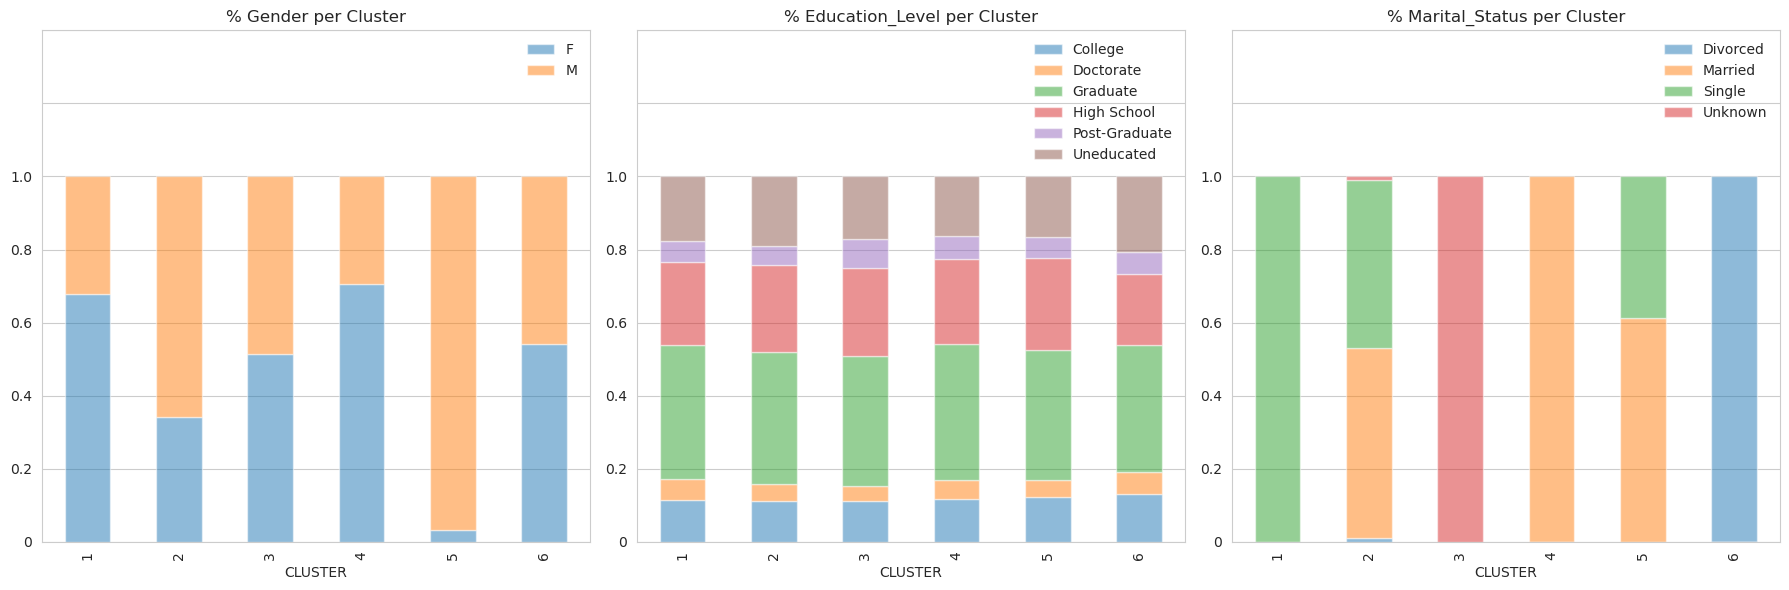

In [104]:
cat_columns = data.select_dtypes(include = ['object'])

fig = plt.figure(figsize = (18,6))
for i, column in enumerate(cat_columns):
    crosstab = pd.crosstab(index = data['CLUSTER'], 
                           columns = data[column],
                           values = data[column], aggfunc = 'size',
                           normalize = 'index')
    ax = fig.add_subplot(1,3,i+1)
    crosstab.plot(kind = 'bar', stacked = True, ax = ax, alpha = 0.5)
    
    ax.set_ylim(0,1.4)
    ax.set_title(f"% {column.title()} per Cluster")
    labels = [0,0.2,0.4,0.6,0.8,1.0]
    ax.set_yticklabels(labels)
    ax.legend(frameon = False)
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()

Going one plot to the other, left to right:
- We see that the gender is pretty evenly spead except for clusters 2 and 5, which favor a more male clientele. 
- This is pretty even across the board. Most people are college graduates with two degrees, the next highest is high school graduates. The lowest population is doctorate academics. 
- The last plot has the most variation. Cluster one is entirely single people. 2 is split between single and married evenly. 3 is entirely unknown, 4 and 5 have majority married. And 6 is all divorcees!

## Decisions
The crosstab plots are informative for the social aspects of clients, but I'm not sure how we would attract those since the most important aspect of credit card usage is income and utilization. We'd want to target the people with the highest income, best credit limits and superior utilization ratios. For clients with less usage, one could target them and offer incentives to utilize their credit cards more often. 

It seems that clusters 2 and 3 offer a good perspective on people who like to use their credit cards and buy lots of things. Cluster 6 is the target for incentives, these people have money but don't seem to buy a lot.

# Conclusion
This project helped me understand the subject of inertia and clusterization. I learned how to improve my plots to make them more viewable and nice to look at. There is still so much I have yet to learn. I'm